In [0]:
%load_ext tensorboard

In [0]:
# from google.colab import files
# files.upload()
#!unzip test1
!ls

adc.json  Cat_Dog_data	Cat_Dog_data.zip  runs	sample_data


# This code is used to download data in google colab

In [1]:
# Load helper file
link = "https://drive.google.com/file/d/1Cn0B9Zr2irUnZcHqODT9IilGHf9fZ61R/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]

print ("Loading file ...")

print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])
print ("Completed")



Loading file ...
1Cn0B9Zr2irUnZcHqODT9IilGHf9fZ61R
Completed


In [0]:
#!unzip Cat_Dog_data


In [0]:
#!kaggle competitions download -c Cat_Dog_data -p /content/

In [0]:
#!ls Cat_Dog_data/

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# Cats and Dogs Classification (Using Convolutionnal Neural Network + Pytorch)

# package we need

In [0]:
import os
import sys
import cv2
import pandas as pd
import random
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torch.utils.data import Dataset

import glob

from PIL import Image

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [0]:
# helper functions to show and denormalize an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg)#, cmap="gray"
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ['dog', 'cat']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])

def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image
# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

## Load the dataset

In [0]:
## Write data loaders for training,  and test sets
## Specify appropriate transforms, and batch_sizes
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
input_size =224*224*3
output_size = 2
n_features =8
# define training, valid and test data directories
data_dir = './Cat_Dog_data/'
train_dir = os.path.join(data_dir, 'train/')
#valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      # transforms.Grayscale(),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor(),
                                    # transforms.Lambda(lambda x: x.repeat(3,1,1)),#])
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])


test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                    #  transforms.Grayscale(),
                                    transforms.ToTensor(),
                                    #  transforms.Lambda(lambda x: x.repeat(3,1,1)),#])
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

visualize_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                    #  transforms.Grayscale(),
                                    transforms.ToTensor()])

#classes = ('dog','cat')
# train_data = datasets.ImageFolder(train_dir, transform=train_transform)
# test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Custom Dataloader

In [0]:
class DatasetLoader(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        if self.file_list[idx][0]==2:
          classLabel = self.file_list[idx][0]-1
        else:
          classLabel = self.file_list[idx][0]
        image = Image.open(fileName)
        if self.transform:
            image = self.transform(image)
        return image, classLabel


In [0]:
train_data = DatasetLoader(train_dir, transform=train_transform)
test_data = DatasetLoader(test_dir, transform=test_transform)

visualize_data = DatasetLoader(train_dir, transform=visualize_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

visualize_loader = torch.utils.data.DataLoader(visualize_data, batch_size=batch_size, 
    num_workers=num_workers)

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0])


In [0]:
#len(next(iter(test_loader))),next(iter(test_loader))

# Data visualization

In [10]:
for batch_idx, (data, target) in enumerate(train_loader):
  print(data.size())
  break

torch.Size([20, 3, 224, 224])


If we just visualise the data that we have loaded we may noticed that the image look too strenge, that is because the images we loaded are normalize.

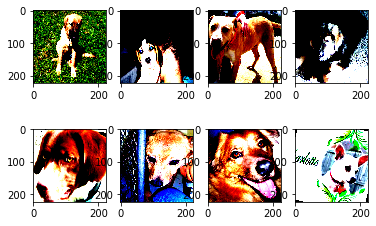

In [11]:
plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0).clip(0,1))

If we want to see our images in the original format, color,... the we need to denormalize them.
 
To do that we use the following function

tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])


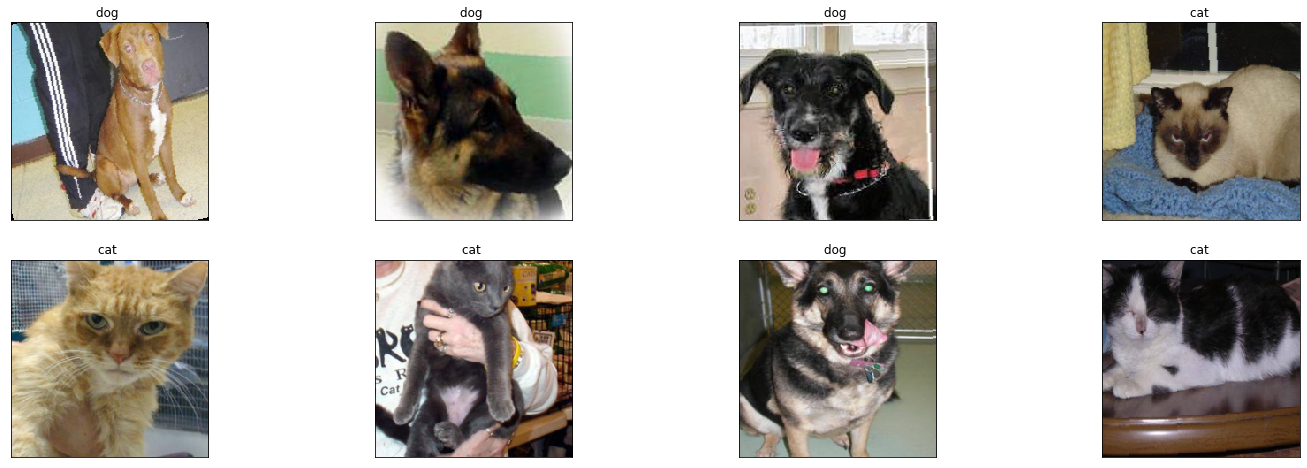

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 8 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format(classes[labels[idx]]))

# Our models :

1. The first model:

* 2 conv with 5x5 as kernel size, stride 1 and no paddind and one fully conected NN

2. The second model 

* 4 conv with 5x5 as kernel size on the 1st,2nd and 3rd conv but 3x3 as kernel size for the last conv plus one fully connected NN


In [0]:
class CNN1(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN1, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*53*53, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*53*53)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    

class CNN2(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=3)
        self.fc1 = nn.Linear(n_feature*11*11, 60)
        self.fc2 = nn.Linear(60, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*11*11)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [0]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cat_dog_experiment_1')

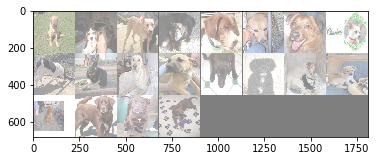

In [17]:
dataiter = iter(visualize_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)
#img_grid = denormalize(img_grid) 
# show images
matplotlib_imshow(img_grid, one_channel=False)


# write to tensorboard

writer.add_image('four_cat_dog_images', img_grid)


In [0]:
net = CNN2(input_size, n_features, output_size)

In [0]:
writer.add_graph(net, images)
writer.close()

In [0]:
#!zip -r runs runs

In [0]:
#!kill 625

In [0]:
#%tensorboard --logdir runs

In [22]:
# helper function to add the projector
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
#images, labels = select_n_random(images[0], labels[0])
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 224 * 224 * 3 )
print(images.shape)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

torch.Size([20, 3, 224, 224])


In [0]:
# helper functions to add the scalar and the plot of the trainning loss

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

# Train and Test functions

In [0]:
accuracy_list = []
# if  torch.cuda.is_available():
#     train_loader = train_loader.cuda()
def train(epoch, model,perm=torch.arange(0, 50176).long()):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        #we chage the device if the GPU is available
        if  torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()
        # permute pixels
#         data = data.view(-1, 224*224)
#         data = data[:, perm]
#         data = data.view(-1, 3, 224, 224)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #if batch_idx % 10 == 0:

          # ...log the running loss
    writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader.sampler) + batch_idx)
            
    writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, data, labels),
                            global_step=epoch * len(train_loader.dataset) + batch_idx)



            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            
            #running_loss = 0.0
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(data), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 50176).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
          # get the inputs; data is a list of [inputs, labels]
          #inputs, labels = data
          #we chage the device if the GPU is available
          if  torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()
          
          # permute pixels
          data = data.view(-1, 224*224)
          data = data[:, perm]
          data = data.view(-1, 3, 224, 224)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
          correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Experiment on CNN

# Train CNN1 network

In [0]:
# Training settings 
n_features =8 # number of feature maps
model_cnn = CNN1(input_size, n_features, output_size)
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_cnn = model_cnn.cuda()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 20):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 1125968

Test set: Average loss: 0.5735, Accuracy: 1784/2500 (71%)


Test set: Average loss: 0.5073, Accuracy: 1909/2500 (76%)


Test set: Average loss: 0.4778, Accuracy: 1941/2500 (78%)


Test set: Average loss: 0.4626, Accuracy: 1971/2500 (79%)


Test set: Average loss: 0.4665, Accuracy: 1950/2500 (78%)


Test set: Average loss: 0.4787, Accuracy: 1930/2500 (77%)


Test set: Average loss: 0.4451, Accuracy: 1989/2500 (80%)


Test set: Average loss: 0.4337, Accuracy: 2004/2500 (80%)


Test set: Average loss: 0.4260, Accuracy: 2014/2500 (81%)


Test set: Average loss: 0.4348, Accuracy: 2008/2500 (80%)


Test set: Average loss: 0.4316, Accuracy: 2026/2500 (81%)


Test set: Average loss: 0.4034, Accuracy: 2051/2500 (82%)


Test set: Average loss: 0.4151, Accuracy: 2041/2500 (82%)


Test set: Average loss: 0.4189, Accuracy: 2059/2500 (82%)


Test set: Average loss: 0.4078, Accuracy: 2061/2500 (82%)


Test set: Average loss: 0.4128, Accuracy: 2070/2500 (83%)


Test set:

# Train CNN2 network

In [26]:
# Training settings 
n_features =8 # number of feature maps
model_cnn = CNN2(input_size, n_features, output_size)
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_cnn = model_cnn.cuda()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 40):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 62670

Test set: Average loss: 0.6501, Accuracy: 1488/2500 (60%)


Test set: Average loss: 0.6363, Accuracy: 1566/2500 (63%)


Test set: Average loss: 0.5788, Accuracy: 1728/2500 (69%)


Test set: Average loss: 0.5096, Accuracy: 1891/2500 (76%)


Test set: Average loss: 0.4723, Accuracy: 1957/2500 (78%)


Test set: Average loss: 0.4680, Accuracy: 1957/2500 (78%)


Test set: Average loss: 0.4497, Accuracy: 1988/2500 (80%)


Test set: Average loss: 0.4413, Accuracy: 1974/2500 (79%)


Test set: Average loss: 0.4254, Accuracy: 2010/2500 (80%)


Test set: Average loss: 0.3830, Accuracy: 2082/2500 (83%)


Test set: Average loss: 0.3851, Accuracy: 2069/2500 (83%)


Test set: Average loss: 0.4224, Accuracy: 2055/2500 (82%)


Test set: Average loss: 0.3769, Accuracy: 2076/2500 (83%)


Test set: Average loss: 0.3978, Accuracy: 2045/2500 (82%)


Test set: Average loss: 0.3542, Accuracy: 2111/2500 (84%)


Test set: Average loss: 0.3193, Accuracy: 2150/2500 (86%)


Test set: A

In [27]:
!zip -r runs runs

  adding: runs/ (stored 0%)
  adding: runs/cat_dog_experiment_1/ (stored 0%)
  adding: runs/cat_dog_experiment_1/projector_config.pbtxt (deflated 73%)
  adding: runs/cat_dog_experiment_1/events.out.tfevents.1579635491.cab29e647f7a.121.2 (deflated 1%)
  adding: runs/cat_dog_experiment_1/00000/ (stored 0%)
  adding: runs/cat_dog_experiment_1/00000/default/ (stored 0%)
  adding: runs/cat_dog_experiment_1/00000/default/sprite.png (deflated 0%)
  adding: runs/cat_dog_experiment_1/00000/default/tensors.tsv (deflated 91%)
  adding: runs/cat_dog_experiment_1/00000/default/metadata.tsv (deflated 89%)
  adding: runs/cat_dog_experiment_1/events.out.tfevents.1579635538.cab29e647f7a.121.4 (deflated 5%)
  adding: runs/cat_dog_experiment_1/events.out.tfevents.1579635487.cab29e647f7a.121.1 (deflated 5%)
  adding: runs/cat_dog_experiment_1/events.out.tfevents.1579635760.cab29e647f7a.121.5 (deflated 9%)
  adding: runs/cat_dog_experiment_1/events.out.tfevents.1579635483.cab29e647f7a.121.0 (deflated 5%)
 

In [0]:
plt.bar(('NN image', 'CNN image','NN scrambled',
         'CNN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');